In [32]:
import requests
from openai import OpenAI
from dotenv import load_dotenv
load_dotenv()
import json

client = OpenAI()
import matplotlib.pyplot as plt

GROUP_THEM_URL = "http://127.0.0.1:8080/groupthem"

### WordGuess

In [9]:
todo

{'guesses': [], 'maximum_guesses': 6}

### GroupThem

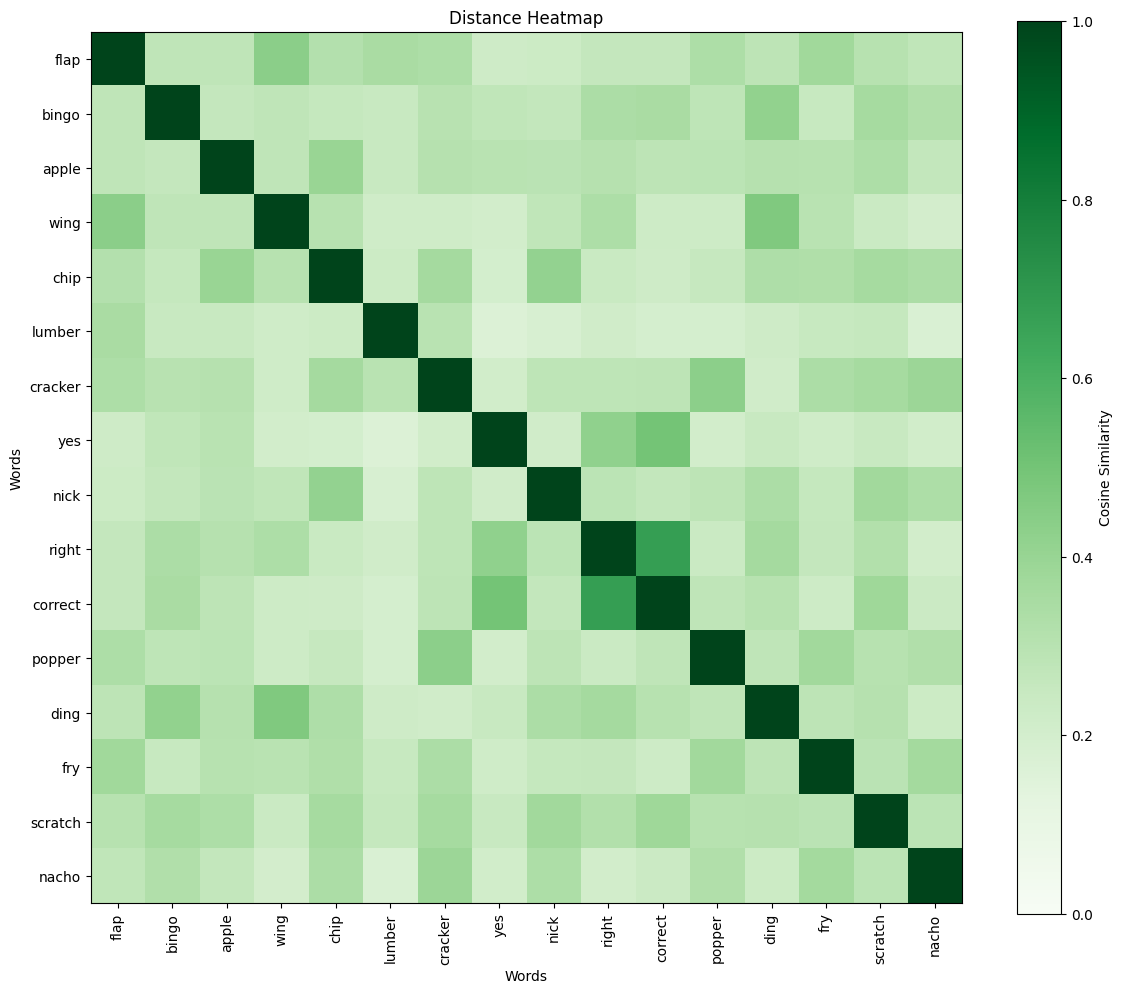

Group 1: flap, wing, fry, lumber
Group 2: bingo, ding, scratch, correct
Group 3: apple, chip, cracker, right
Group 4: yes, nick, nacho, popper


In [37]:
# Embed all words
state = requests.get(GROUP_THEM_URL).json()
words = state["available_words"]

embeddings = [
    x.embedding for x in client.embeddings.create(
        model="text-embedding-3-large",
        input=state["available_words"]
    ).data
]

amount = len(embeddings)
import numpy as np
# Compare all items to eachother
similarity_matrix = np.zeros((amount, amount))

for i in range(amount):
    for j in range(amount):
        if i != j:
            similarity_matrix[i, j] = np.dot(embeddings[i], embeddings[j])
        else:
            similarity_matrix[i, j] = 1

# Plot the similarity matrix as a grid of squares with word labels
plt.figure(figsize=(12, 10))
plt.imshow(similarity_matrix, cmap='Greens', interpolation='nearest', vmin=0, vmax=1)

# Add color bar to interpret the shading
plt.colorbar(label='Cosine Similarity')

# Set tick labels to words
plt.xticks(ticks=np.arange(amount), labels=words, rotation=90)
plt.yticks(ticks=np.arange(amount), labels=words)

# Add labels for better readability
plt.title('Distance Heatmap')
plt.xlabel('Words')
plt.ylabel('Words')

# Show plot
plt.tight_layout()
plt.show()

# Group words into 4 groups based on similarity
groups = []
used_words = set()

for i, word in enumerate(words):
    if word in used_words:
        continue

    # Get similarities for the current word and sort indices based on similarity
    sorted_indices = np.argsort(-similarity_matrix[i])  # Sort in descending order
    # Exclude the word itself and take the top 4 most similar
    group = [word]
    for idx in sorted_indices[1:]:
        if len(group) == 4:
            break
        neighbor_word = words[idx]
        if neighbor_word not in used_words:
            group.append(neighbor_word)

    # Add group to the list if it has exactly 4 members
    if len(group) == 4:
        groups.append(group)
        used_words.update(group)

# Display the groups
for i, group in enumerate(groups):
    print(f"Group {i + 1}: {', '.join(group)}")

In [38]:
from collections import defaultdict
from enum import Enum

models = ["gpt-4o", "gpt-4o-2024-08-06", "gpt-4o-mini", "gpt-3.5-turbo"]
schema = '{"reasoning": String, "connections": [String; 4]}'

class Status(Enum):
    WIN = 1
    LOSE = 2
    DROPPED = 3
    UKNWN = 4

result = {model: {"guesses": defaultdict(int)} for model in models}

FREQUENCY_INCREASE = 0.7
TEMPERATURE_INCREASE = 0.1
TEMPERATURE_DEFAULT = 0.5

def process(model: str):
    frequency_penalty = 0
    temperature = TEMPERATURE_DEFAULT
    s = requests.Session()
    state = s.get(GROUP_THEM_URL).json()
    conversation = [
        {"role": "system", "content": "You are a helpful assistant. Create a json object with the connection groups & your reasoning. ### Schema\n" + schema },
        {"role": "user", "content": "Create the mentioned JSON object through trying to find a connection between exactly 4 of these items: " + ", ".join(state["available_words"]) + "."},
    ]
    
    for i in range(10):
        # Ask model to attempt connection
        response = client.chat.completions.create(
            model=model,
            messages=conversation,
            temperature=max(0, min(temperature, 1.2)),
            frequency_penalty=max(0, min(frequency_penalty, 2)),
        ).choices[0].message.content
        
        start = response.find("{")
        end = response.find("}", start)
        
        try:
            json_response = json.loads(response[start:end+1])
        except Exception as e:
            print(response)
            print(e)
            conversation.append({"role": "user", "content": "Invalid JSON object. Please try again following the schema: " + schema})
        
        conversation.append({"role": "assistant", "content": response})
        
        print(f"\n>Guess: {json_response['connections']}\nReasoning: {json_response['reasoning']}")
        # Send connections
        payload = {"guess": json_response["connections"]}
        
        try:
            response = s.post(GROUP_THEM_URL, json=payload)
            if response.status_code != 200:
                
                result[model]["guesses"][Status.DROPPED] += 1
                frequency_penalty += FREQUENCY_INCREASE
                temperature += TEMPERATURE_INCREASE
                if "guess already made" in response.text.lower():
                    conversation.append({"role": "user", "content": "WARNING: This guess was already made"})
                    print("Guess already made")
                    continue
                
                if "not a valid word" in response.text.lower():
                    conversation.append({"role": "user", "content": f"WARNING: {response.text}"})
                    print("Invalid word")
                    continue
                else:
                    print(f"\n### {response.text}")
                    break
            available_words = response.json()["available_words"]
        except Exception as e:
            print(e)
            break
        
        win = json_response["connections"][0] not in available_words
        print(f"Win: {win}\n")
        if len(available_words) == 0:
            print(f"### You won in {i+1} guesses!")
            result[model]
            break
        else:
            
            if win:
                frequency_penalty = 0
                temperature = TEMPERATURE_DEFAULT
                result[model]["guesses"][Status.WIN] += 1
                conversation = [
                    {"role": "system", "content": "You are a helpful assistant. Create a json object with the connection groups & your reasoning. ### Schema\n" + schema },
                    {"role": "user", "content": "Create the mentioned JSON object through trying to find a connection between exactly 4 of these items: " + ", ".join(available_words) + "."},
                ]
            else:
                frequency_penalty += FREQUENCY_INCREASE
                temperature += TEMPERATURE_INCREASE
                result[model]["guesses"][Status.LOSE] += 1
                conversation.append(
                    {"role": "user", "content": "INCORRECT. Important: Try again with DIFFERENT options."}
                )

for model in models:
    print(f"# Model: {model}")
    process(model)
    print("\n---\n")

            

# Model: gpt-4o

>Guess: ['chip', 'fry', 'cracker', 'nacho']
Reasoning: The connection between the items is that they all can be preceded by the word 'potato' to form common phrases or food items.
Win: False


>Guess: ['flap', 'wing', 'ding', 'scratch']
Reasoning: The connection between the items is that they all can be associated with the concept of 'flying' or 'air travel.'
Win: False


>Guess: ['bingo', 'chip', 'scratch', 'nick']
Reasoning: The connection between the items is that they all can be associated with games or activities.
Win: False


>Guess: ['yes', 'right', 'correct', 'ding']
Reasoning: The connection between the items is that they can all be related to correctness or affirmation.
Win: False


>Guess: ['apple', 'cracker', 'nacho', 'fry']
Reasoning: The connection between the items is that they can all be associated with foods.

### You have reached the maximum number of guesses

---

# Model: gpt-4o-2024-08-06

>Guess: ['chip', 'cracker', 'popper', 'nacho']
Reasoning: T

### Convert to a graph

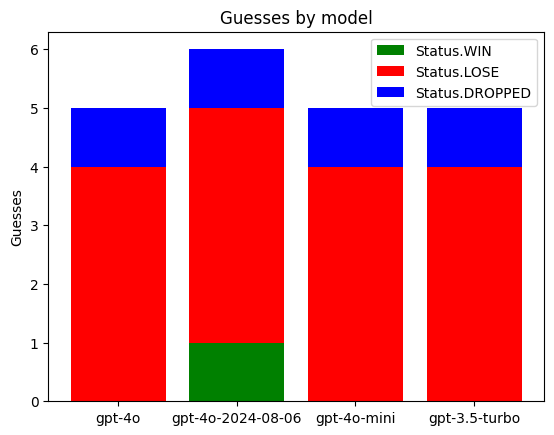

In [39]:


fig, ax = plt.subplots()

for model in models:
    win = result[model]["guesses"][Status.WIN]
    lose = result[model]["guesses"][Status.LOSE]
    dropped = result[model]["guesses"][Status.DROPPED]
    
    ax.bar(model, win, color='g')
    ax.bar(model, lose, bottom=win, color='r')
    ax.bar(model, dropped, bottom=win+lose, color='b')

ax.set_ylabel('Guesses')
ax.set_title('Guesses by model')
ax.legend([Status.WIN, Status.LOSE, Status.DROPPED])
plt.show()